In [1]:
import platform
import pickle
import os
from datetime import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 自动加载修改的模块, 即导入的module遭到修改不需要手动重新导入
%load_ext autoreload
%autoreload 2

# load datasets

In [3]:
### load data

### load一个pickle文件
### python2是ASCII,3是unicode编码-->用当前python的编码方式打开pickle的文件
def load_pickle(file):
  #get python version (major, minor, patchlevel)
  version=platform.python_version_tuple()
  if version[0] == '2':
    return pickle.load(file)
  elif version[0] == '3':
    return pickle.load(file,encoding='latin1')
  raise ValueError("invalid python version: {}".format(version))

### load一个batch文件
def load_CIFAR_batch(filename):
  with open(filename,'rb') as f:
    datadict=load_pickle(f)
    #print(datadict)
    #print(type(datadict))
    X=datadict['data']
    Y=datadict['labels']
    X=X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("float")#从10000*3*32*32变成10000*32*32*3,并变为float型矩阵
    Y=np.array(Y) # class list转变成ndarray
    return X,Y

### load数据集中所有batch
def load_CIFAR10(ROOT):
    xs=[]
    ys=[]

    for i in range(1,6):
        f=os.path.join(ROOT,'data_batch_%d'%i)
        X,Y=load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr=np.concatenate(xs)#把5个train batches拼起来
    Ytr=np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [4]:
cifar10_dir=r'D:\deep-learning\CV\data\cifar-10-batches-py'##colab无法访问本地文件, 需要上传文件

try:#但凡有一个变量不存在, 都会引发NameError异常。except块会捕获这个异常，并防止程序崩溃
    del x_train,y_train
    del x_test,y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


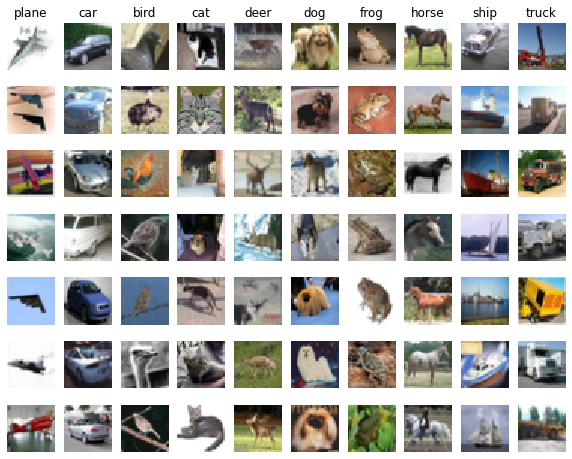

<Figure size 200x160 with 0 Axes>

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)#flatnonzero返回input的非零索引
    #即idxs为train中属于第y类的索引
    idxs = np.random.choice(idxs, samples_per_class, replace=False)#随机选samples_per_class个, 不能重复选
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.figure(dpi=20)
plt.show()

plane


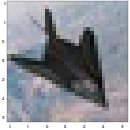

In [6]:
#随机展示图片
type_pic=np.random.randint(0,len(classes)-1)#y_train从0~9
for i,cls in enumerate(classes):
    if(type_pic==i):
        idxs=np.flatnonzero(y_train==i)
        print(cls)
rand_pic=np.random.choice(idxs,1)
plt.figure(dpi=20)
plt.imshow(X_train[rand_pic[0]].astype('uint8'))

## 展示完成, 开始实现KNN

In [6]:
### 取1/10数据

# 取一部分出来把图像矩阵拉直
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

(5000, 3072) (500, 3072)


In [7]:
# Reshape the image data into rows

X_train = np.reshape(X_train, (X_train.shape[0], -1))#-1表自己推这个维度要给多大
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(50000, 3072) (10000, 3072)


In [20]:
#################################################################################
print(X_test.shape[0])

print(len(X_test[0]))
print(len(X_test[0]-X_train))#直接算出X_train张差值
print(X_test[0])
print(np.square(X_test[0]))


500
3072
5000
[158. 112.  49. ...  21.  67. 110.]
[24964. 12544.  2401. ...   441.  4489. 12100.]


In [ ]:
# KNN
from builtins import range
from builtins import object
#import numpy as np
from past.builtins import xrange

# KNN类的实现

In [8]:
class KNearestNeighbor(object):
    
    def __init__(self):
        pass
    
    def train(self,x,y):
        self.X_train=x
        self.y_train=y
        
    def predict(self,X_test,k=1,distances_num=0):
        nums={0:self.distance_zero,1:self.distance_one,2:self.distance_two}#字典里存函数入口地址,仅是计算的循环层数,都是L2距离
        if distances_num in range(0,3):
            dists=nums[distances_num](X_test)
        else:
            raise ValueError('Invalid value %d for num_loops' % distances_num)
        return self.predict_label(dists,k=k)
    
    def predict_label(self,dists,k=1):
        #dists是X_test*X_train大小的距离矩阵
        num_test=dists.shape[0]
        y_pred=np.zeros(num_test)
        for i in range(num_test):
            closest_y=[]
            max_index=np.argsort(dists[i])#返回升序排序序号
            for j in range(k):
                index=max_index[j]#获得第j小的X_train序号
                closest_y.append(self.y_train[index])
            #已获得k个邻居的类别closest_y
            maxdir={}
            sy=set(closest_y)#获得无序不重复的set
            for s in sy:
                count=closest_y.count(s)
                maxdir[s]=count#closest_y中各个类别各有多少邻居
            y_pred[i]=int(max(maxdir,key=maxdir.get))#哪类邻居多就归于哪类,key后的函数表示找谁的最大值
        return y_pred
            
    def distance_zero(self,X):
        num_test=X.shape[0]
        num_train=self.X_train.shape[0]
        dists=np.zeros((num_test,num_train))
        dists=np.sqrt(np.sum(X**2,axis=1,keepdims=True)+np.sum(self.X_train**2,axis=1,keepdims=True).T-2*np.dot(X,self.X_train.T))
        return dists
        
    def distance_one(self,X):
        num_test=X.shape[0]
        num_train=self.X_train.shape[0]
        dists=np.zeros((num_test,num_train))
        for i in range(num_test):
            dists[i,:]=np.sqrt(np.sum(np.square((X[i]-self.X_train)),axis=1))
        return dists
        
    def distance_two(self,X):
        #Euclidean distance
        num_test=X.shape[0]
        num_train=self.X_train.shape[0]
        dists=np.zeros((num_test,num_train))#num_test组num_train个的评分
        for i in range(num_test):
            for j in range(num_train):
                dists[i,j]=np.sqrt(np.sum(np.square(X[i]-self.X_train[j])))
        return dists

# KNN的使用

In [9]:
### 获得距离矩阵

classifier=KNearestNeighbor()
classifier.train(X_train,y_train)
dists=classifier.distance_zero(X_test)
print(dists.shape)

(10000, 50000)


<Figure size 500x400 with 0 Axes>

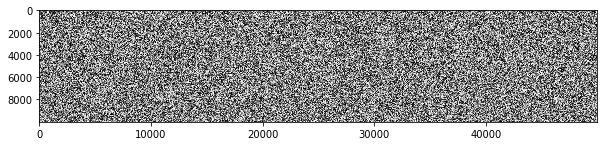

<Figure size 500x400 with 0 Axes>

In [10]:
#可视化获得的距离矩阵
plt.imshow(dists.astype('uint8'),interpolation='none')
plt.figure(dpi=50)

wrong predict type:  bird
true type:  dog
Got 3539 / 10000 correct => accuracy: 0.353900


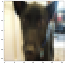

In [11]:
## 看看分错的图片被分到哪一类了, k=1
y_pred = classifier.predict(X_test)
worning=np.flatnonzero(y_pred-y_test)
#print(y_pred)
i=np.random.randint(0,len(worning))
#print(X_test.shape)
plt.figure(dpi=10)
plt.imshow(np.reshape(X_test[worning[i]],(32,32,3)).astype('uint8'))
for k,cls in enumerate(classes):
    if y_test[worning[i]]==k:
        print('true type: ',cls)
    if y_pred[worning[i]]==k:
        print('wrong predict type: ',cls)
        
## 看看分类准确率
right=len(y_pred)-len(worning)
accuracy=right/len(y_pred)
print('Got %d / %d correct => accuracy: %f' % (right, len(y_pred), accuracy))

In [30]:
###############################################################################################################################

X_test.shape[0]-worning.shape[0]
print(len(y_pred))
print(len(worning))

500
363


In [25]:
###############################################################################################################################

a=np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a[0,2])
print(a**2)

a=np.random.random((3,3))
print(a)
print(np.argsort(a))

3
[[ 1  4  9]
 [16 25 36]
 [49 64 81]]
[[0.10999645 0.24797875 0.43675759]
 [0.38844152 0.04072046 0.64204356]
 [0.38966593 0.25322717 0.07275636]]
[[0 1 2]
 [1 0 2]
 [2 1 0]]


In [76]:
###############################################################################################################################

class test(object):
    def __init__(self):
        pass
    def p(self,num):
        nums={0:self.zero,1:self.one}
        if num in {0,1}:
            nums[num]()
            print("here")
        
    def zero(self):
        print("zero")
        
    def one(self):
        print(456789)
        
a=test()
a.p(1)

456789
here


## K

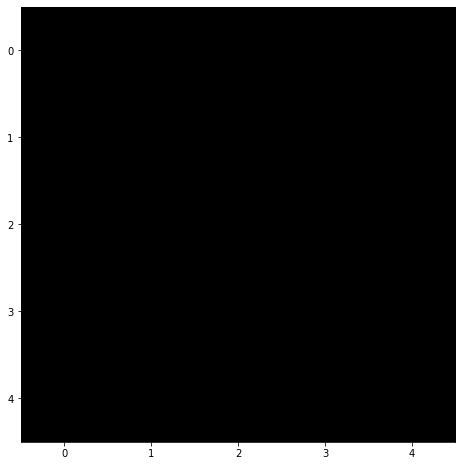

In [33]:
###############################################################################################################################

plt.imshow(np.zeros((5,5)))
# 即越黑表明距离越近

In [35]:
## 尝试改变超参数--->k=5
y_pred_5=classifier.predict_label(dists,k=5)
right_5=np.sum(y_pred_5==y_test)
accuracy_5=float(right_5)/len(y_pred)
print('Got %d / %d correct => accuracy: %f' % (right_5, len(y_pred), accuracy_5))


Got 139 / 500 correct => accuracy: 0.278000


### Cross-validation
将train分num_folds组,每组train分别都做一次test,以此找出最佳k

In [12]:
# 利用train data找最佳k

num_folds=5
k_choices=[1,3,5,8,10,12,15,20,30,50,80,100]

X_train_folds=np.array_split(X_train,num_folds)
y_train_folds=np.array_split(y_train,num_folds)

k_to_accuracies={}

step=int(X_train.shape[0]/num_folds)
for k in k_choices:
    acc=[]
    for i in range(num_folds):
        train_data=np.concatenate([X_train[:i*step], X_train[(i+1)*step:]], axis = 0)#数组拼接
        test_data = X_train[i*step:(i+1)*step]
        train_label = np.concatenate([y_train[:i*step], y_train[(i+1)*step:]], axis = 0)
        test_label = y_train[i*step:(i+1)*step]

        classifier0 = KNearestNeighbor()
        classifier0.train(train_data, train_label)
        dists = classifier0.distance_zero(test_data)
        label_test_pred = classifier0.predict_label(dists, k=k)
        num_correct = np.sum(label_test_pred == test_label)
        #acc.append(float(num_correct) / num_test)
        acc.append(float(num_correct) / len(test_label))
        
    k_to_accuracies[k] = acc

KeyboardInterrupt: 

In [1]:
for k in sorted(k_to_accuracies):
    right=0
    for accuracy in k_to_accuracies[k]:
        #print('k = %d, accuracy = %f' % (k, accuracy))#输出每个k的5组训练结果
        right+=accuracy
    print('k = %d, accuracy = %f' % (k, right/len(k_to_accuracies[k])))#输出每个k的平均训练结果

NameError: name 'k_to_accuracies' is not defined

In [78]:
print(k_to_accuracies)

{1: [0.526, 0.514, 0.528, 0.556, 0.532], 3: [0.482, 0.498, 0.486, 0.546, 0.528], 5: [0.512, 0.542, 0.56, 0.578, 0.556], 8: [0.526, 0.574, 0.552, 0.576, 0.54], 10: [0.532, 0.592, 0.558, 0.566, 0.566], 12: [0.522, 0.588, 0.56, 0.566, 0.56], 15: [0.506, 0.58, 0.558, 0.56, 0.55], 20: [0.54, 0.558, 0.558, 0.56, 0.568], 30: [0.544, 0.544, 0.572, 0.53, 0.544], 50: [0.542, 0.576, 0.556, 0.538, 0.532], 80: [0.52, 0.546, 0.536, 0.512, 0.54], 100: [0.512, 0.54, 0.526, 0.512, 0.526]}


In [75]:
print(len(X_train_folds))
print(X_train_folds[0].shape)
print(X_train.shape)

5
(1000, 3072)
(5000, 3072)


In [11]:
# 发生了什么??? k=1的准确率怎么变这么高了???
k_1_pred=classifier.predict(X_test)
k_1_right=np.sum(k_1_pred==y_test)
print('accuracy 0f k=1: ',k_1_right/len(k_1_pred))

## 不是吧...过于看运气了...

accuracy 0f k=1:  0.3539


In [12]:
k_10_pred=classifier.predict(X_test,k=10)
k_10_right=np.sum(k_10_pred==y_test)
print('accuracy 0f k=10: ',k_10_right/len(k_10_pred))

accuracy 0f k=10:  0.3385


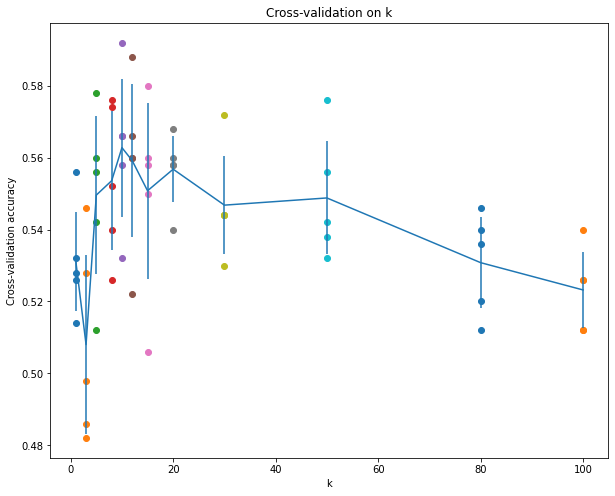

In [100]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [101]:
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


# vectorization 
see significantly faster performance with the fully vectorized implementation!

distance two one zero的vectorization使用程度不断加大, 看看时间区别

In [65]:
## 检查三种欧式距离计算方式所得结果是否相同
dists_one=classifier.distance_one(X_test)
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [66]:
dists_two=classifier.distance_two(X_test)
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [52]:
def time_function(f,*args):
    import time
    tic=time.time()
    f(*args)
    toc=time.time()
    return toc-tic

two_loop_time=time_function(classifier.distance_two,X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time=time_function(classifier.distance_one,X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time=time_function(classifier.distance_zero,X_test)
print('Zero loop version took %f seconds' % no_loop_time)

Two loop version took 40.771486 seconds
One loop version took 58.715471 seconds
Zero loop version took 0.193511 seconds
